In [6]:
# If you don't already have it...
#import sys
#!{sys.executable} -m pip install nflows
#!{sys.executable} -m pip install uproot

### Extracting and inverting transformations

Up until now, I've managed to train a flow to go from a Gaussian to the LHCb simulated IP distribution of Z->mu mu decays. 

It'll work just as well from a Gaussian to the data shape.

If this were to be used in an analysis, we'd need to tie these together into 1 2-step transformation.

Then we need to be able to extract the transformation as a 1-to-1 function that we can apply, rather than a sampling.

First of all, let's use a v.simple test transform of e.g. 1D Gaussian -> Gaussian to work out how to string 2 transforms together, and then extract a transformation function. We could then apply the transformation function on another sample to check that it works fine.  

In [4]:
from nflows import transforms, distributions, flows
import torch
import matplotlib.pyplot as plt

In [5]:
def make_basic_flow(hidden_features=4):
    transform = transforms.CompositeTransform([
        transforms.MaskedAffineAutoregressiveTransform(features=2, hidden_features=hidden_features),
        transforms.RandomPermutation(features=2)
    ])
    base_distribution = distributions.StandardNormal(shape=[2])
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    return flow

In [8]:
N_SAMPLES = 1000

In [9]:
def train_flow(flow, target):
    optimizer = torch.optim.Adam(flow.parameters())
    n_iter = 5000
    for i in range(n_iter):
        #flow.train() # Put it in training mode.

        # TODO Need to understand why we zero_grad() before calculating the loss.
        # TODO also need to understand the loss
        # TODO why no forward pass?
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=target).mean()
        loss.backward()
        optimizer.step()

        ### Testing the thing
        # flow.eval() # Put it in evaluation mode.
        with torch.inference_mode():
            if i % 1000 == 0:
                print(f"Loss at iteration {i}: {loss}")
                xline = torch.linspace(-10, 10, 100)
                yline = torch.linspace(-10, 10, 100)
                xgrid, ygrid = torch.meshgrid(xline, yline)
                xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

                zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

                plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
                plt.title('iteration {}'.format(i + 1))
                plt.show()

In [11]:
# Generate some data to flow to as we did in the first tutorial
torch.manual_seed(42)
target = 2.0 * torch.randn(N_SAMPLES, 2) + 5

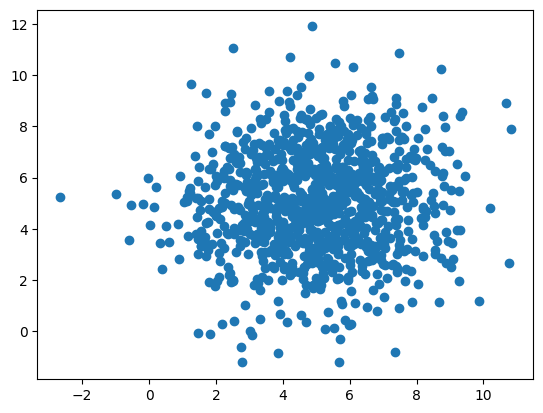

In [12]:
plt.figure()
plt.scatter(target[:, 0], target[:, 1])
plt.show()

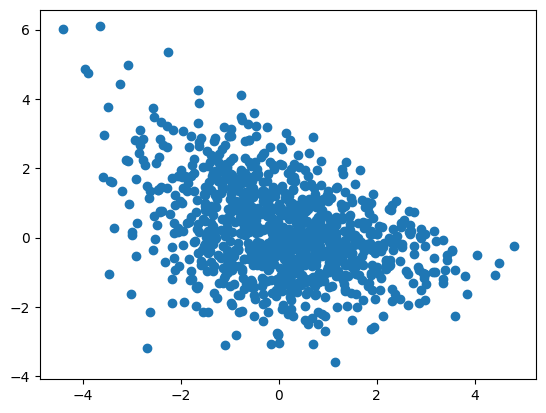

In [14]:
# Plot the base distribution of the flow i.e. the initial state
flow = make_basic_flow()
with torch.inference_mode():
    pretrain_samples = flow.sample(N_SAMPLES)
    plt.figure()
    plt.scatter(pretrain_samples[:, 0], pretrain_samples[:, 1])
    plt.show()

Bit weird, but OK. Looks roughly like a 2D Gaussian.

Now let's do the flow.

Loss at iteration 0: 56.92915725708008


/home/epp/phrrkw/.local/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


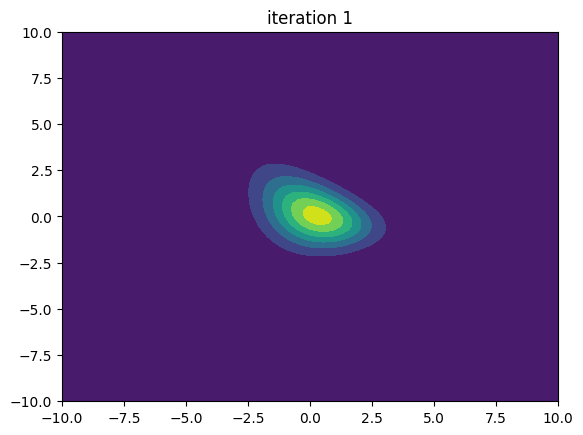

Loss at iteration 1000: 5.041438102722168


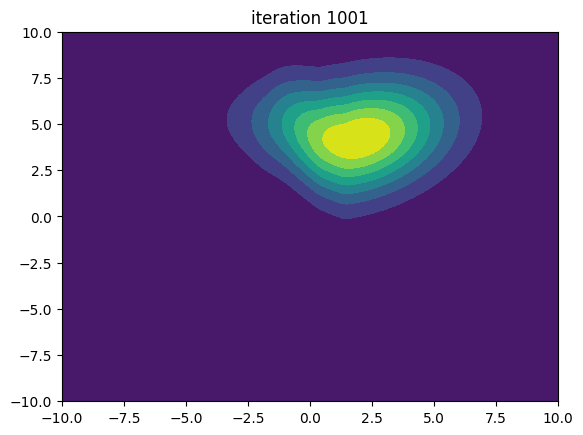

Loss at iteration 2000: 4.42051362991333


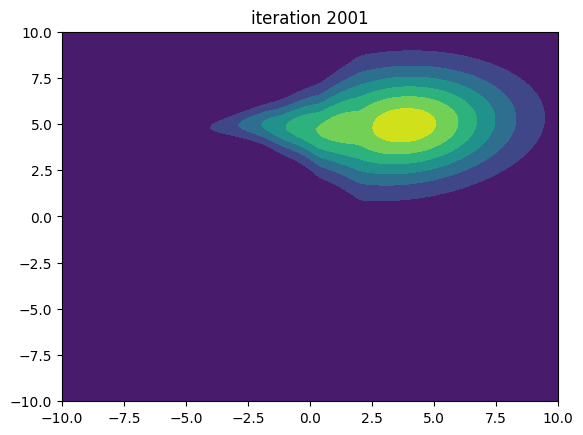

Loss at iteration 3000: 4.327910423278809


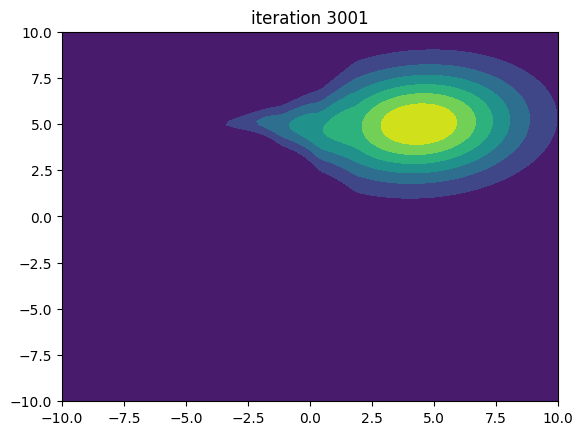

Loss at iteration 4000: 4.2646660804748535


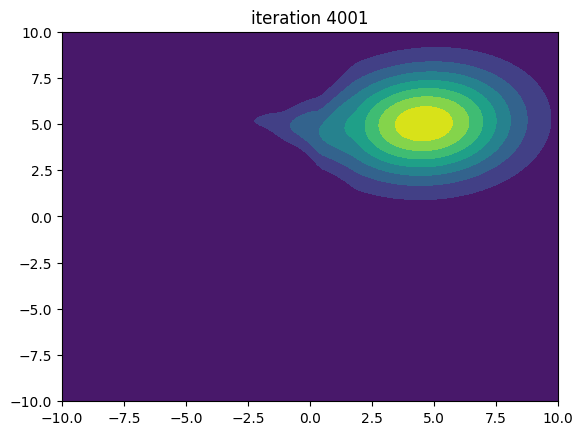

In [15]:
train_flow(flow, target)

It has pretty much worked. Strange tail, but the quality of the flow is not so important for now, what I want to test if I can extract the transformation.

So now let's draw another sample of a 2D standard gaussian, and apply the transformation with the `forward` method of the flow.

<class 'torch.Tensor'>


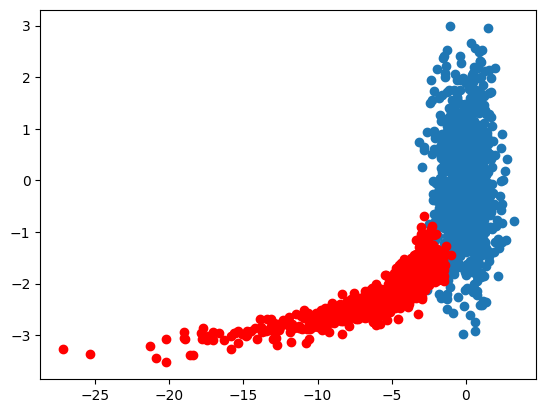

In [23]:
# Draw another sample
indep_sample = torch.randn(N_SAMPLES, 2)#.reshape(-1, 1)

# Will need to make it a tensor with a dummy batch dimension
print(type(indep_sample))
# flow.forward isnt allowed
# transform_to_noise doesn't sound like what I want but try...
transformed = flow.transform_to_noise(indep_sample)

with torch.inference_mode():
    plt.figure()
    plt.scatter(indep_sample[:, 0], indep_sample[:, 1])
    plt.scatter(transformed[:, 0], transformed[:, 1], color='red')
    plt.show()

Well, that's certainly not what we are after.

A ``nflows.Transform`` object has a `forward` and `inverse` method. Why doesn't the flow, or how do I access the transform of the flow?

In [24]:
print(transformed)

tensor([[ -5.7990,  -2.4340],
        [ -6.3449,  -2.0840],
        [-17.7120,  -2.8689],
        ...,
        [ -5.6643,  -2.3505],
        [ -2.5722,  -1.9608],
        [ -2.6943,  -1.4598]], grad_fn=<IndexSelectBackward0>)


Could it be that the `transform_to_noise` function should be applied to the target, and it will get it back to the noise, i.e. the inverse transformation? It looks like that could be right.

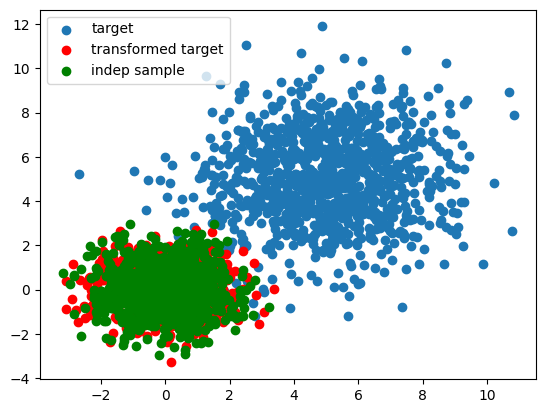

In [28]:
transformed_target = flow.transform_to_noise(target)
with torch.inference_mode():
    plt.figure()
    plt.scatter(target[:, 0], target[:, 1], label='target')
    plt.scatter(transformed_target[:, 0], transformed_target[:, 1], color='red', label='transformed target')
    plt.scatter(indep_sample[:, 0], indep_sample[:, 1], color='green', label='indep sample')
    plt.legend()
    plt.show()

Indeed, that is what it does. So we have found the inverse transformation, and we can apply it a given dataset. That's one of our goals :tick:

So now, in the end we are going to do LHCb simulated IP -> Gaussian -> LHCb data IP as our total transformation. After training a Gaussian -> simulated IP flow, it's clear that we could employ `transform_to_noise` to go backwards. This is indeed a 1-to-1 mapping of the simulated shape to a Gaussian. Now we need to know how to (without sampling) employ a forward transformation of a flow.

Reading the doc string of a `Flow` object, and looking also at the `transform_to_noise` function, I just need to put in an `inverse` somewhere.

Reading through the issue list on GitHub again, I came across mention of `transforms.InverseTransform`, which you construct with another transform. So can I construct it with a pre-trained transform? That would mean I need to pull the `transform` out of my flow.

In [29]:
inverse = transforms.InverseTransform(flow._transform)

(tensor([[ 6.1553,  3.6369],
        [ 0.0842,  4.8026],
        [-0.3536,  3.4100],
        ...,
        [ 5.5574,  3.9984],
        [ 7.7313,  5.9047],
        [ 4.6625,  8.0369]], grad_fn=<DivBackward0>), tensor([ 1.5302,  0.8875,  0.6759,  1.2477,  1.5339,  1.5074,  1.5045,  1.5243,
         1.2930,  1.5089,  1.5475,  1.5103,  0.5868,  1.5145,  1.5284,  1.5039,
         1.5147,  1.5207,  1.5237,  1.2906,  1.5127,  1.5368,  1.5106,  1.5140,
         1.5272,  1.5354,  1.5298,  1.5200,  1.5154,  1.5335,  1.5284,  1.5309,
         1.5461,  1.3527,  1.5324,  1.5313,  1.5257,  1.5151,  1.5324,  1.5263,
         1.5327,  1.4375,  1.5081,  1.5340,  0.6070, -0.1886,  1.5266,  1.5272,
         1.5309,  1.5520,  1.5064,  1.5121,  1.5252,  1.5228,  1.5252,  1.5285,
         1.5340,  1.5548,  1.5208,  1.5019,  1.5255,  1.5174,  1.5342,  1.5091,
         1.5406,  1.5403,  1.5279,  1.5056,  1.5214,  1.5250,  1.5415,  1.5184,
         1.5236,  1.5265,  1.5279,  1.5264,  1.5269,  1.5210,  1.5065,  

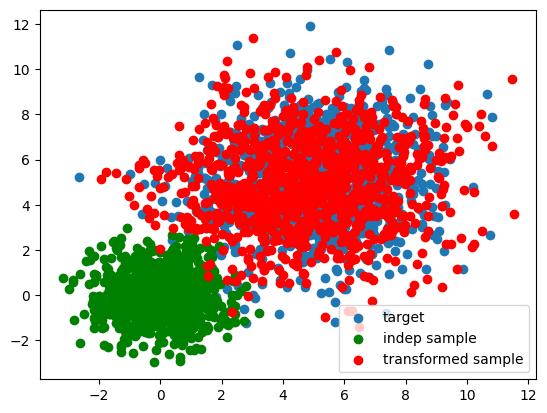

In [37]:
inverse_data = inverse.forward(indep_sample)
print(inverse_data)
print(type(inverse_data))
print(type(inverse_data[0]))
print(inverse_data[0].shape)
with torch.inference_mode():
    plt.figure()
    plt.scatter(target[:, 0], target[:, 1], label='target')
    plt.scatter(indep_sample[:, 0], indep_sample[:, 1], color='green', label='indep sample')
    plt.scatter(inverse_data[0][:, 0], inverse_data[0][:, 1], color='red', label='transformed sample')
    plt.legend()
    plt.show()

Et voila again! So now I seem to have found a hacky way to extract the inverse transform. 

It was a bit of a hack. Looking back at what I did, it was in total `InverseTransform(flow._transform).forward()`. Calling a ~private member function is a hack, but if had the transform around (rather than just letting it go out of scope in the `make_basic_flow` function), then I could just do `InverseTransform(transform).forward()`. Still a bit weird. 

Could I have just done `transform.inverse()`?

Let's try and instance the flow in a different way then.

In [38]:
def make_basic_flow_return_transform(hidden_features=4):
    transform = transforms.CompositeTransform([
        transforms.MaskedAffineAutoregressiveTransform(features=2, hidden_features=hidden_features),
        transforms.RandomPermutation(features=2)
    ])
    base_distribution = distributions.StandardNormal(shape=[2])
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    return flow, transform

Loss at iteration 0: 12.869156837463379


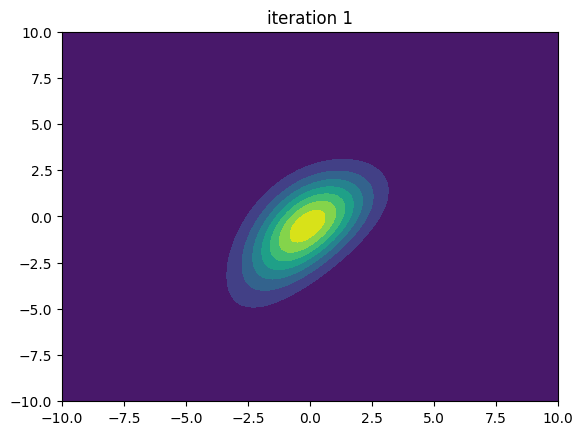

Loss at iteration 1000: 5.000482082366943


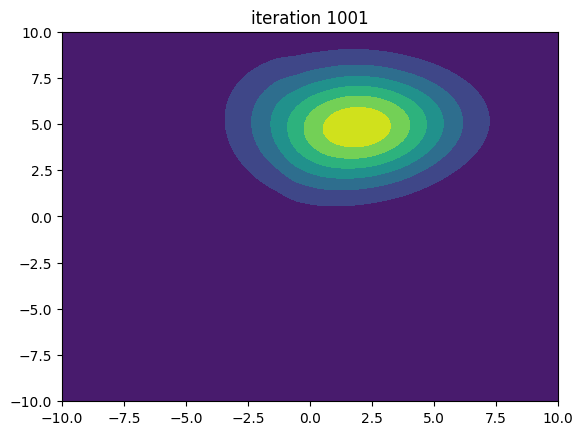

Loss at iteration 2000: 4.480544090270996


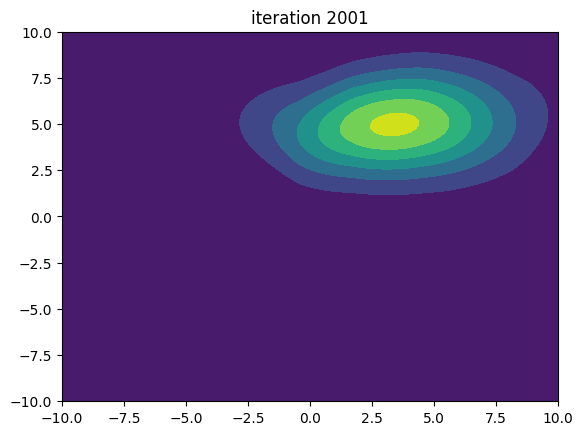

Loss at iteration 3000: 4.367896556854248


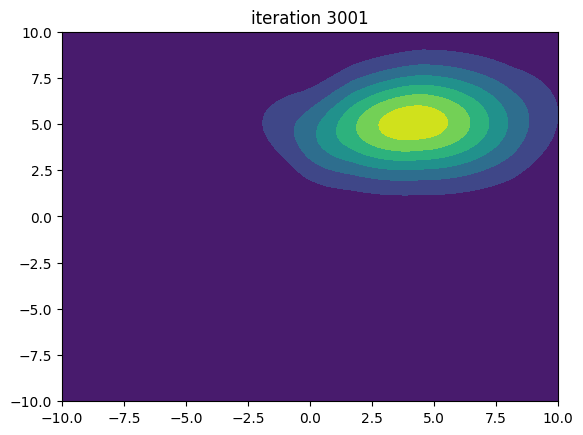

Loss at iteration 4000: 4.2779083251953125


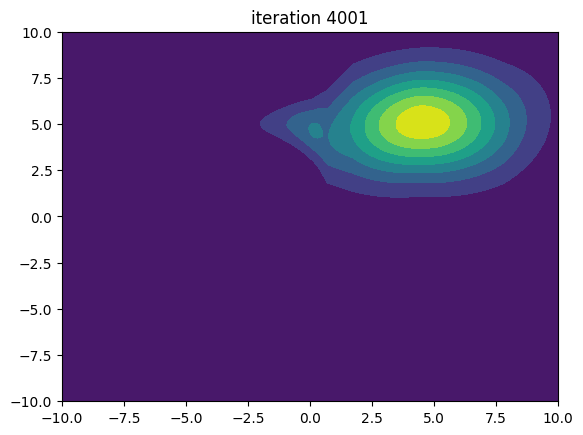

In [39]:
new_flow, new_transform = make_basic_flow_return_transform()
train_flow(new_flow, target)

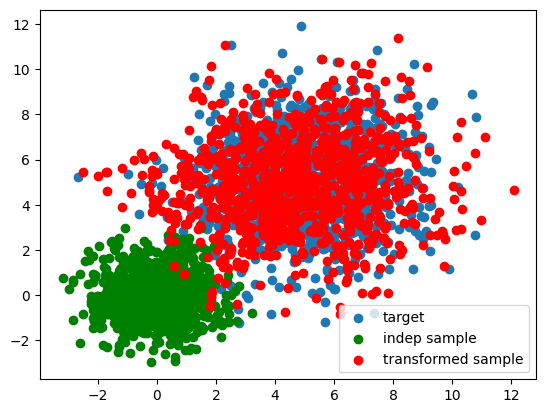

In [40]:
inverse_data = new_transform.inverse(indep_sample)
with torch.inference_mode():
    plt.figure()
    plt.scatter(target[:, 0], target[:, 1], label='target')
    plt.scatter(indep_sample[:, 0], indep_sample[:, 1], color='green', label='indep sample')
    plt.scatter(inverse_data[0][:, 0], inverse_data[0][:, 1], color='red', label='transformed sample')
    plt.legend()
    plt.show()

Yep, that worked perfectly, and showed that we don't need the `Flow.transform_to_noise` function, we can just get at it via the `Transform.forward` function. It might even be that the `operator()` is overloaded for this, since it does inherit from a `nn.Module`.

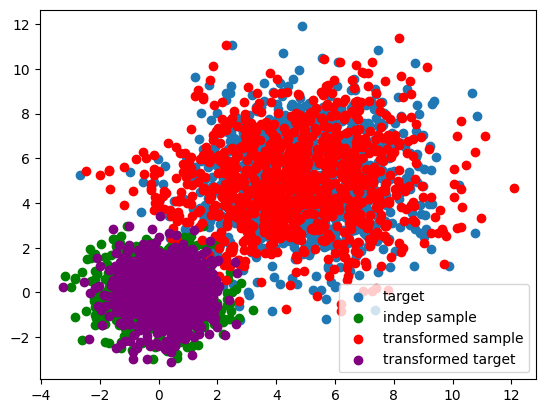

In [41]:
transformed_target = new_transform(target)
with torch.inference_mode():
    plt.figure()
    plt.scatter(target[:, 0], target[:, 1], label='target')
    plt.scatter(indep_sample[:, 0], indep_sample[:, 1], color='green', label='indep sample')
    plt.scatter(inverse_data[0][:, 0], inverse_data[0][:, 1], color='red', label='transformed sample')
    plt.scatter(transformed_target[0][:, 0], transformed_target[0][:, 1], color='purple', label='transformed target')
    plt.legend()
    plt.show()

Yep, indeed, `operator()` is overloaded, we see above that we can go from target to noise via `operator()`. This is all in line with the naming of "normalising flows" - they are **normalising** in the sense that they turn data into a normal distribution. This is commented on in the [issue that I read to point me in the right direction with all this](https://github.com/bayesiains/nflows/issues/32).